## 1. Load and summarize cis-variance predictions from FlashZoi

First we'll compare the two gene sets to understand their different characteristics:


In [16]:
import os, glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

sns.set_theme(style="whitegrid")


clingen_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/ClinGen_gene_curation_list"
nonessential_scored_dir = "/Users/markus/seq2expr-variance/data/output/dataset3/flashzoi_outputs/nonessential_ensg"

clingen_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv"
nonessential_cache = "/Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv"

gtex_expr_file = "..//data/initial/GTEx_Analysis_2022-06-06_v10_RNASeQCv2.4.2_gene_median_tpm.gct"

gene_metrics_vgh = "/Users/markus/seq2expr-variance/data/initial/gene_metrics_vgh_202407.tsv.gz"

In [17]:
def load_variants_summary(
        variants_scored_dir: str,
        cache_file: str,
        min_af: float = 0.01,
        force_reload: bool = False
    ) -> pd.DataFrame:
    """
    Build a per-gene summary table from scored-variant folders.
    variants_scored_dir : str
        Path containing one sub-folder per gene, each with <gene>_variants.tsv.
    cache_file : str
        Where the summary TSV will be cached / read from.
    min_af : float, optional
        Minimum alternate-allele frequency (inclusive) to keep a variant. Filtering the common variants here
    force_reload : bool, optional
        Ignore an existing cache and rebuild the summary
    """
    if os.path.exists(cache_file) and not force_reload:
        var_df = pd.read_csv(cache_file, sep="\t")
        print(f"Loaded cached gene summary table: {cache_file}")
        return var_df

    records = []
    for folder in glob.glob(os.path.join(variants_scored_dir, "*")):
        gene_id  = os.path.basename(folder)
        var_file = os.path.join(folder, f"{gene_id}_variants.tsv")
        if not os.path.isfile(var_file):
            continue

        df = pd.read_csv(var_file, sep="\t")
        df.columns = df.columns.str.upper()

        if "AF" not in df.columns:
            continue  # skip malformed tables
        df["AF"] = pd.to_numeric(df["AF"], errors="coerce")
        before = len(df)
        df = df[df["AF"] >= min_af].reset_index(drop=True)
        after = len(df)
        # Uncomment for debugging:
        # print(f"{gene_id}: kept {after}/{before} variants with AF ≥ {min_af}")

        if df.empty or not {"VAR_I", "DELTA"}.issubset(df.columns):
            continue

        up_mask   = df["DELTA"] >  0
        down_mask = df["DELTA"] <  0

        records.append({
            "gene_id": gene_id,
            "predicted_cis_variance": df["VAR_I"].sum(),
            "num_snps": len(df),
            "mean_AF": df["AF"].mean(),
            "median_AF": df["AF"].median(),
            "mean_DELTA": df["DELTA"].mean(),
            "median_DELTA": df["DELTA"].median(),
            "mean_VAR_I": df["VAR_I"].mean(),
            "median_VAR_I": df["VAR_I"].median(),
            "predicted_cis_variance_up"   : df.loc[up_mask,   "VAR_I"].sum(),
            "predicted_cis_variance_down" : df.loc[down_mask, "VAR_I"].sum(),
            "num_snps_up"                 : up_mask.sum(),
            "num_snps_down"               : down_mask.sum(),
        })

    var_df = pd.DataFrame(records)
    var_df.to_csv(cache_file, sep="\t", index=False)
    print(f"Saved gene summary to: {cache_file}")
    return var_df

var_df_clingen = load_variants_summary(clingen_scored_dir, clingen_cache,
                                       min_af=0.01, force_reload=True)
var_df_nonessential = load_variants_summary(nonessential_scored_dir, nonessential_cache,
                                            min_af=0.01, force_reload=True)

print("ClinGen:", var_df_clingen.shape)
print(var_df_clingen.head())
print("Non-essential:", var_df_nonessential.shape)
print(var_df_nonessential.head())

sns.set_theme(style="whitegrid")

var_df_clingen      = var_df_clingen.copy()
var_df_nonessential = var_df_nonessential.copy()
var_df_clingen["cohort"]      = "ClinGen"
var_df_nonessential["cohort"] = "Non-essential"
var_df_all = pd.concat([var_df_clingen, var_df_nonessential], ignore_index=True)
var_df_all["cohort"] = "Combined"

cohort_dfs = {
    "ClinGen"        : var_df_clingen,
    "Non-essential"  : var_df_nonessential,
    "Combined"       : var_df_all
}


Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/clingen_summary_corrected_tracks.tsv
Saved gene summary to: /Users/markus/seq2expr-variance/data/intermediate/dataset3/cache/nonessential_summary_corrected_track.tsv
ClinGen: (314, 13)
           gene_id  predicted_cis_variance  num_snps   mean_AF  median_AF  \
0  ENSG00000015171            5.192293e-07      1993  0.224439   0.083773   
1  ENSG00000089225            8.054877e-07      2875  0.176341   0.078200   
2  ENSG00000182774            3.950705e-04      2685  0.164024   0.065789   
3  ENSG00000096696            1.180269e-04      2848  0.216798   0.123680   
4  ENSG00000179348            5.482736e-07      2364  0.198366   0.053371   

     mean_DELTA  median_DELTA    mean_VAR_I  median_VAR_I  \
0 -7.799352e-07  0.000000e+00  2.605265e-10  9.501787e-13   
1 -3.529641e-06 -7.059425e-07  2.801696e-10  1.369285e-12   
2  9.653000e-05  4.816055e-05  1.471399e-07  9.763669e-10   
3 -3.176069e-05 -3.3

## 1. Exploring single gene

In [27]:
_SCORED_FOLDERS = {
    "ClinGen"       : clingen_scored_dir,
    "Non-essential" : nonessential_scored_dir,
}

def _pick_id(df, fallback_cols=("CHR", "POS")):
    for cand in ("RSID", "ID", "SNP", "VAR_ID"):
        if cand in df.columns:
            return cand
    if all(col in df.columns for col in fallback_cols):
        return fallback_cols
    return None  # will use df.index later

def plot_gene_variants(
        gene_id: str,
        cohort : str,
        top_n  : int = 3,
        label_cols: tuple | list | None = None):
    fpath = Path(_SCORED_FOLDERS[cohort]) / gene_id / f"{gene_id}_variants.tsv"
    if not fpath.exists():
        print(f"Variant file not found: {fpath}")
        return

    df = pd.read_csv(fpath, sep="\t")
    df.columns = df.columns.str.upper()
    if df.empty or {"VAR_I", "DELTA"}.difference(df.columns):
        print("Table lacks VAR_I or DELTA.")
        return

    df["direction"] = np.where(df["DELTA"] > 0, "Up", "Down")
    df["AF"] = pd.to_numeric(df["AF"], errors="coerce")

    # choose label column(s)
    id_key = label_cols or _pick_id(df)
    def _lab(row):
        if id_key is None:
            return f"idx {row.name}"
        if isinstance(id_key, str):
            return str(row[id_key])
        # (CHR, POS) tuple
        return f"{row[id_key[0]]}:{row[id_key[1]]}"

    df_top = df.nlargest(top_n, "VAR_I").copy()
    df_top["label"] = df_top.apply(_lab, axis=1)

    # per-direction sums
    up_sum   = df.loc[df["direction"] == "Up",   "VAR_I"].sum()
    down_sum = df.loc[df["direction"] == "Down", "VAR_I"].sum()
    total_sum = up_sum + down_sum

    # cohort-level rankings
    cohort_df = var_df_clingen if cohort == "ClinGen" else var_df_nonessential
    total_rank = cohort_df["predicted_cis_variance"].rank(ascending=False, method="min")
    ratio = cohort_df["predicted_cis_variance_up"] / cohort_df["predicted_cis_variance_down"].replace(0, np.nan)
    ratio_rank = ratio.rank(ascending=False, method="min")
    r_tot  = (total_rank[cohort_df["gene_id"] == gene_id])
    r_ud   = (ratio_rank[cohort_df["gene_id"] == gene_id])
    n_genes = len(cohort_df)

    sns.set_theme(style="whitegrid")
    fig, ax = plt.subplots(1, 4, figsize=(18, 4))

    # 1 AF vs delta
    sns.scatterplot(df, x="AF", y="DELTA", size="VAR_I",
                    hue="direction", palette={"Up":"steelblue","Down":"orangered"},
                    sizes=(20, 200), alpha=.6, ax=ax[0], legend=False)
    ymax = np.nanmax(np.abs(df["DELTA"])) * 1.05
    ax[0].set_ylim(-ymax, ymax); ax[0].axhline(0, color='grey', lw=.8)
    ax[0].set_xscale("log")
    ax[0].set_xlabel("Allele frequency (log)")
    ax[0].set_ylabel("Δ predicted expression")
    ax[0].set_title("Per-variant effect")

    for _, row in df_top.iterrows():
        txt = f"{row['label']}\nAF={row['AF']:.2f}\nΔ={row['DELTA']:.2e}"
        ax[0].annotate(txt, xy=(row["AF"], row["DELTA"]),
                       xytext=(5, 5), textcoords="offset points",
                       fontsize=7)

    # stacked bar
    ax[1].bar(["Up","Down"], [up_sum, down_sum], color=["steelblue","orangered"])
    ax[1].set_yscale("log"); ax[1].set_ylabel("Σ VAR_I"); ax[1].set_title("Total cis-variance")

    # histogram
    sns.histplot(df["VAR_I"], bins=40, log_scale=True, color="grey", ax=ax[2])
    ax[2].set_xlabel("VAR_I (log)"); ax[2].set_ylabel("Count"); ax[2].set_title("VAR_I distribution")

    # cumulative
    df_sorted = df.sort_values("VAR_I", ascending=False).reset_index(drop=True)
    cum_frac = df_sorted["VAR_I"].cumsum() / total_sum
    ax[3].plot(cum_frac, marker=".", lw=1.5)
    ax[3].axhline(.95, ls="--", color="red"); ax[3].axvline(top_n-1, ls="--", color="grey")
    ax[3].set_ylim(0,1.05); ax[3].set_xlabel("Variant rank"); ax[3].set_ylabel("Cumulative Σ VAR_I")
    ax[3].set_title("Variance concentration") # Does a single regulatory SNP dominate this gene’s dosage variability, or is the variance shared across many SNPs?”

    fig.suptitle(f"{gene_id} - {cohort}\n"
                 f"rank ΣVAR_I {r_tot}/{n_genes}   "
                 f"rank Up/Down ratio {r_ud}/{n_genes}",
                 fontsize=14, weight="bold")
    fig.tight_layout(rect=[0,0,1,0.88])


    save_root = Path("/Users/markus/seq2expr-variance/3_aggregate/dataset3/figures/single_cell")
    subfolder = "clingen" if cohort.lower().startswith("clingen") else "non_essential"
    out_dir   = save_root / subfolder
    out_dir.mkdir(parents=True, exist_ok=True)
    plt.show()

    fig.savefig(out_dir / f"{gene_id}_dashboard.png", dpi=300)

    print(f"{gene_id}  ({cohort})")
    print(f"variants: {len(df)}   up: {sum(df['direction']=='Up')}   down: {sum(df['direction']=='Down')}")
    print(f"Σ VAR_I up   = {up_sum:.2e}")
    print(f"Σ VAR_I down = {down_sum:.2e}")
    if total_sum: print(f"Up fraction  = {up_sum/total_sum:.2%}")
    print(f"rank ΣVAR_I  = {r_tot}/{n_genes}")
    print(f"rank Up/Down = {r_ud}/{n_genes}")


## 1.1 Clingen cohort

### 1.2 Top 4 genes in clingen cohort which are having the biggest signal

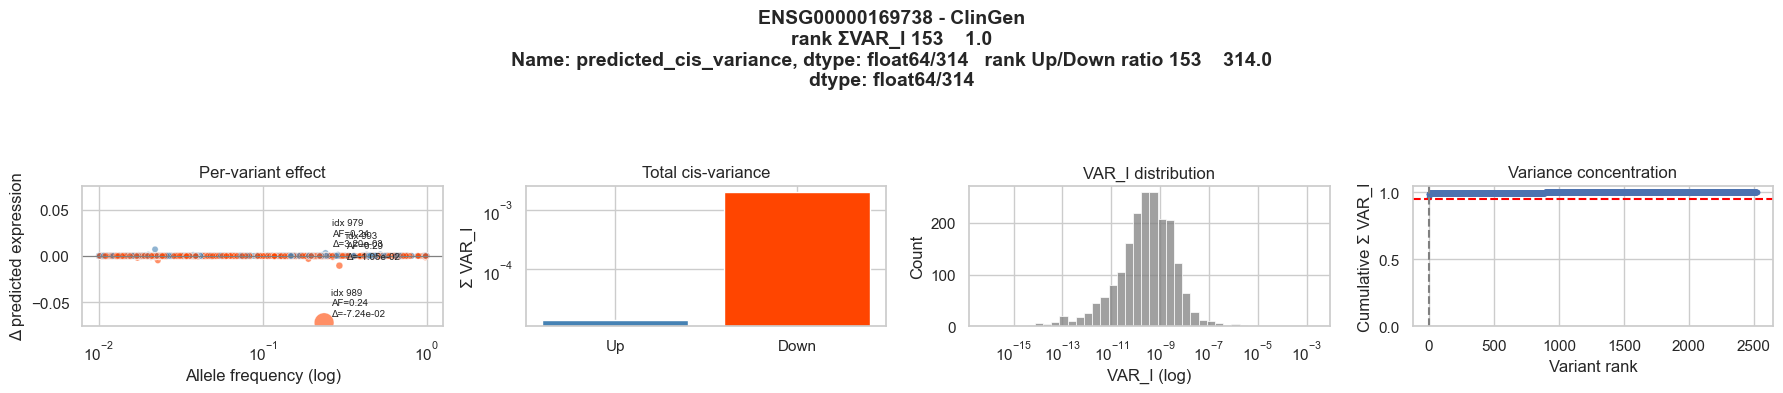

ENSG00000169738  (ClinGen)
variants: 2523   up: 1063   down: 1460
Σ VAR_I up   = 1.44e-05
Σ VAR_I down = 1.95e-03
Up fraction  = 0.73%
rank ΣVAR_I  = 153    1.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 153    314.0
dtype: float64/314


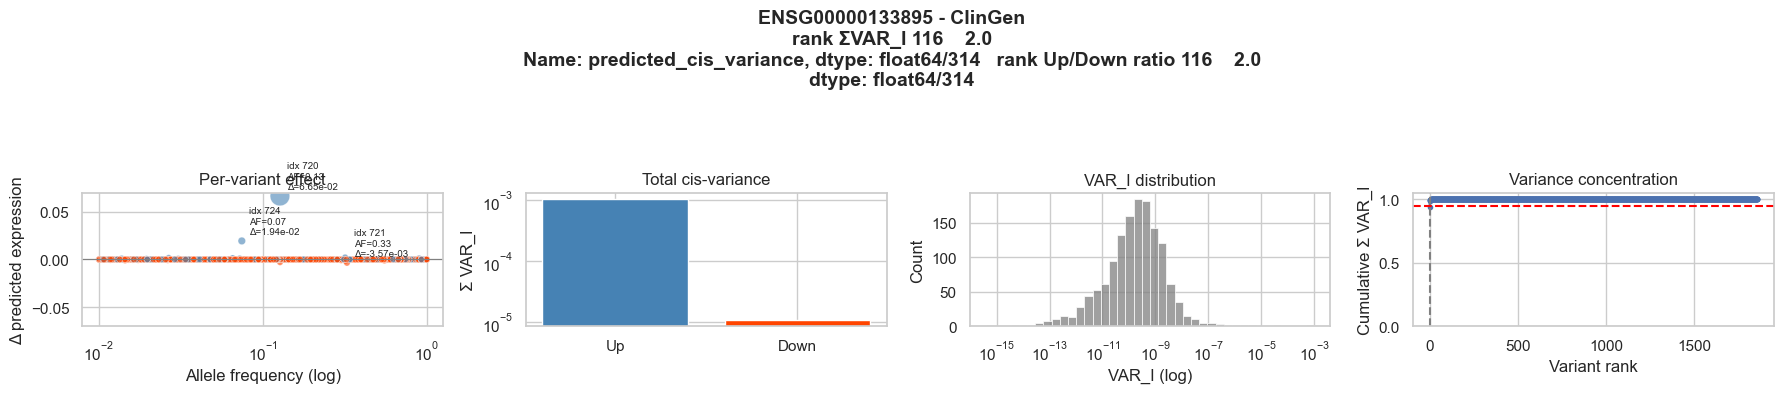

ENSG00000133895  (ClinGen)
variants: 1860   up: 469   down: 1391
Σ VAR_I up   = 1.04e-03
Σ VAR_I down = 1.07e-05
Up fraction  = 98.98%
rank ΣVAR_I  = 116    2.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 116    2.0
dtype: float64/314


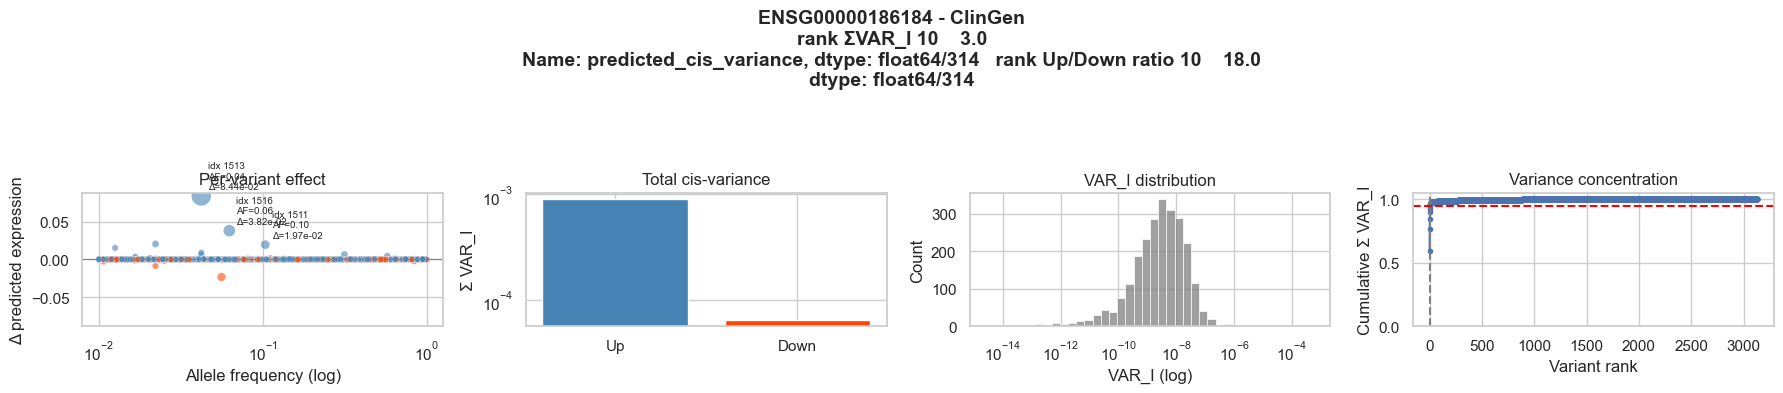

ENSG00000186184  (ClinGen)
variants: 3134   up: 2241   down: 893
Σ VAR_I up   = 9.09e-04
Σ VAR_I down = 6.38e-05
Up fraction  = 93.44%
rank ΣVAR_I  = 10    3.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 10    18.0
dtype: float64/314


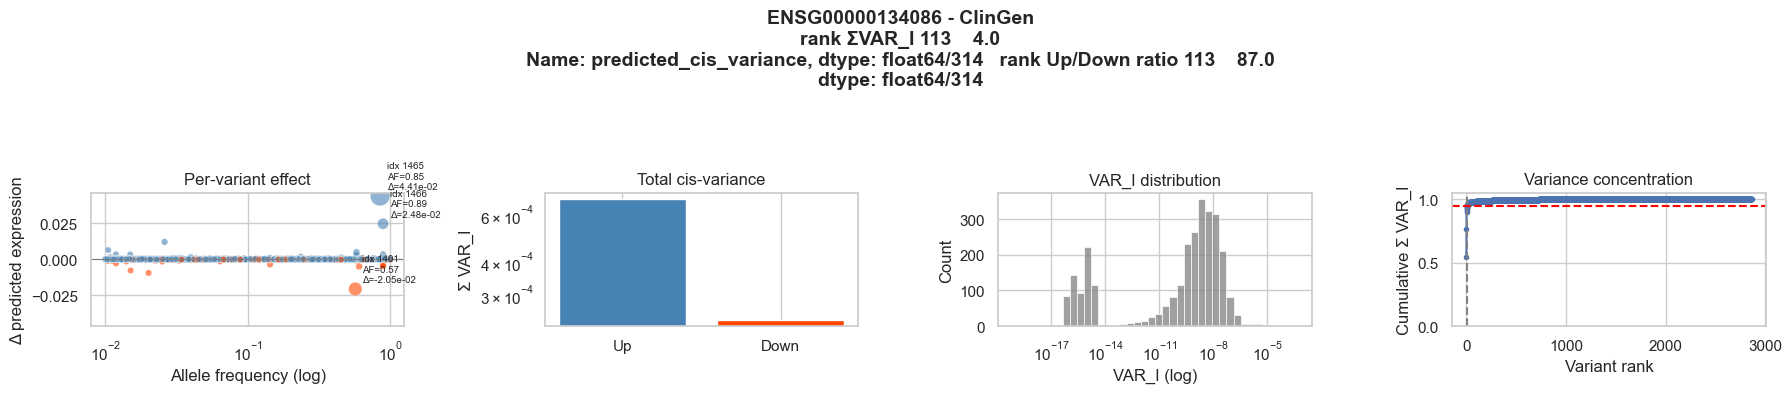

ENSG00000134086  (ClinGen)
variants: 2862   up: 2522   down: 340
Σ VAR_I up   = 6.81e-04
Σ VAR_I down = 2.39e-04
Up fraction  = 74.06%
rank ΣVAR_I  = 113    4.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 113    87.0
dtype: float64/314


In [28]:
top_by_var = (
    var_df_clingen.sort_values("predicted_cis_variance", ascending=False)
                  .head(4)["gene_id"]
)

for g in top_by_var:
    plot_gene_variants(g, cohort="ClinGen")

### 1.1.2 The most extreme up–down imbalance

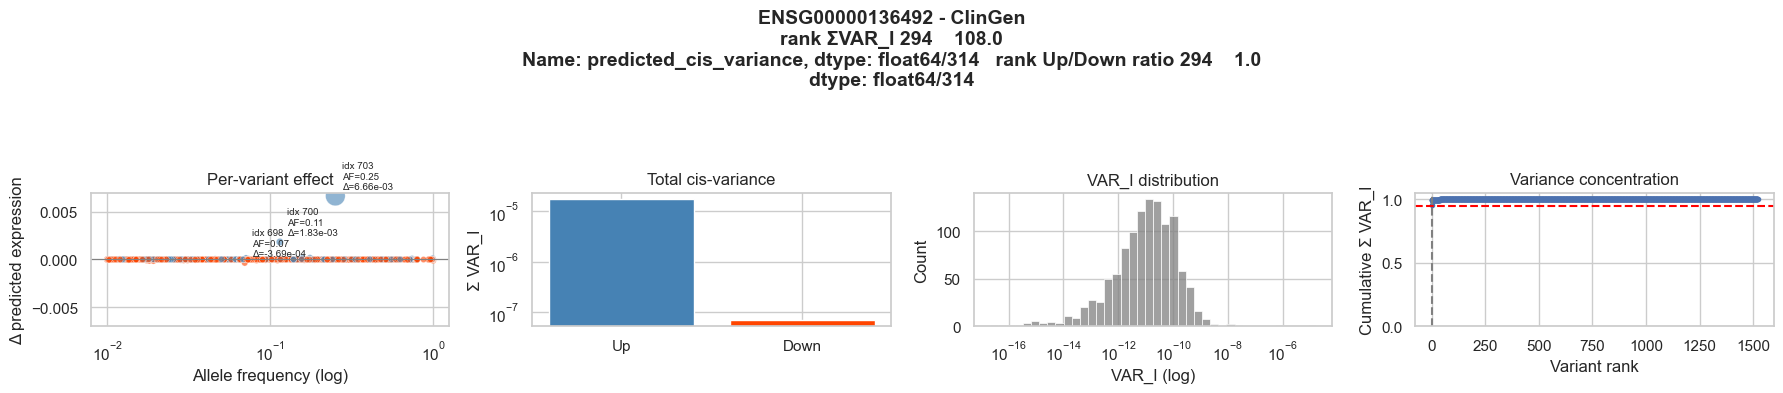

ENSG00000136492  (ClinGen)
variants: 1522   up: 464   down: 1058
Σ VAR_I up   = 1.74e-05
Σ VAR_I down = 6.99e-08
Up fraction  = 99.60%
rank ΣVAR_I  = 294    108.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 294    1.0
dtype: float64/314


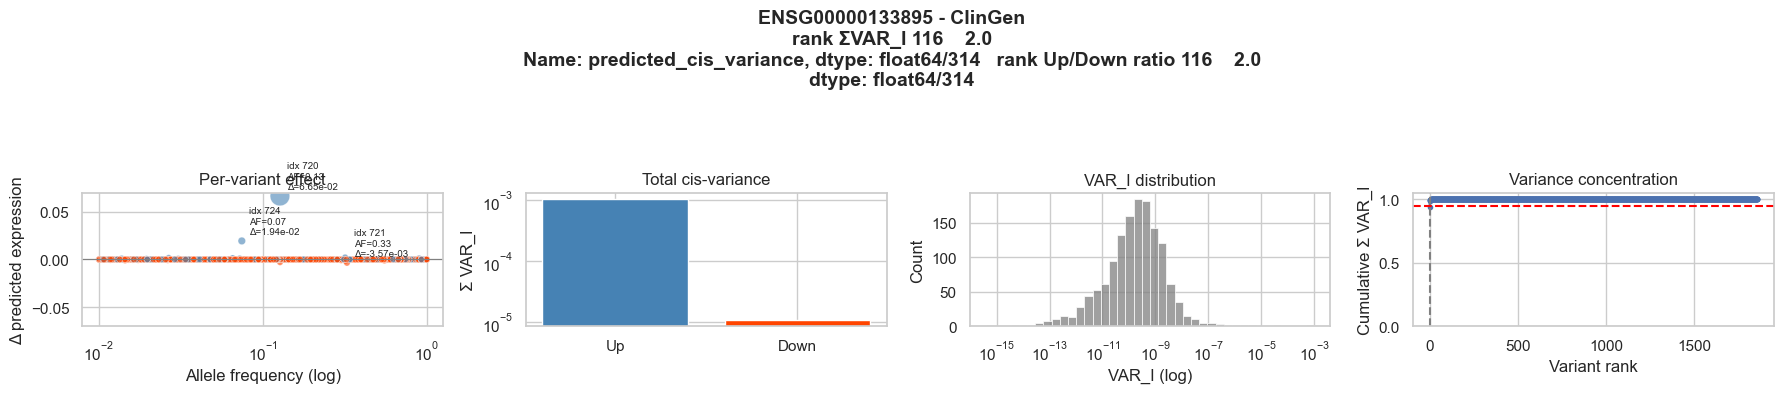

ENSG00000133895  (ClinGen)
variants: 1860   up: 469   down: 1391
Σ VAR_I up   = 1.04e-03
Σ VAR_I down = 1.07e-05
Up fraction  = 98.98%
rank ΣVAR_I  = 116    2.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 116    2.0
dtype: float64/314


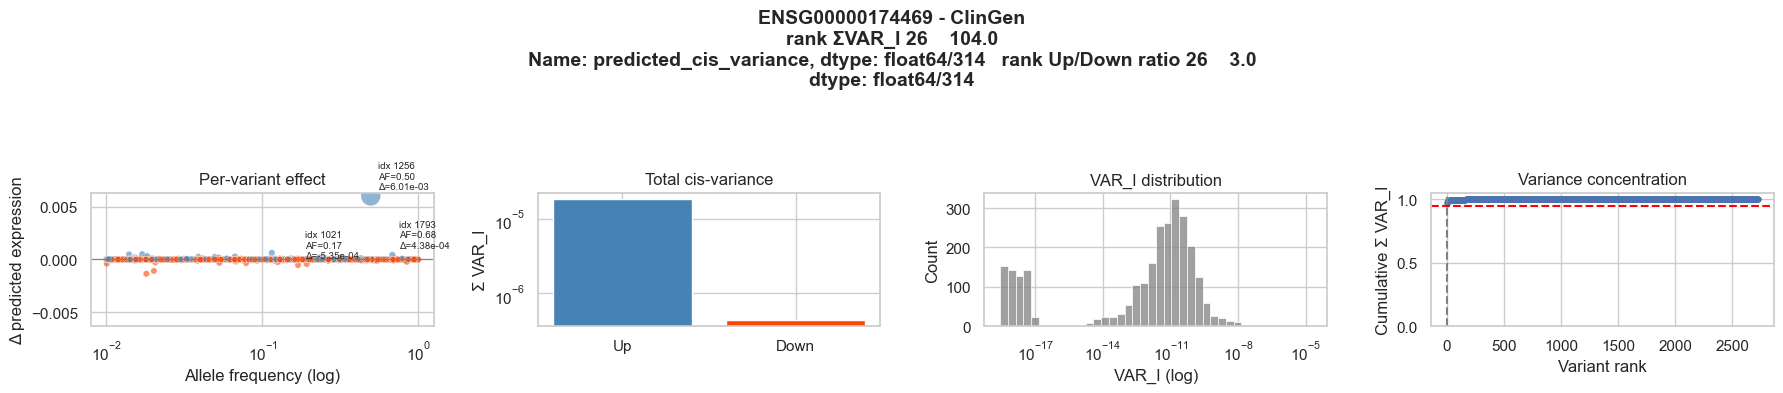

ENSG00000174469  (ClinGen)
variants: 2729   up: 987   down: 1742
Σ VAR_I up   = 1.84e-05
Σ VAR_I down = 4.41e-07
Up fraction  = 97.66%
rank ΣVAR_I  = 26    104.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 26    3.0
dtype: float64/314


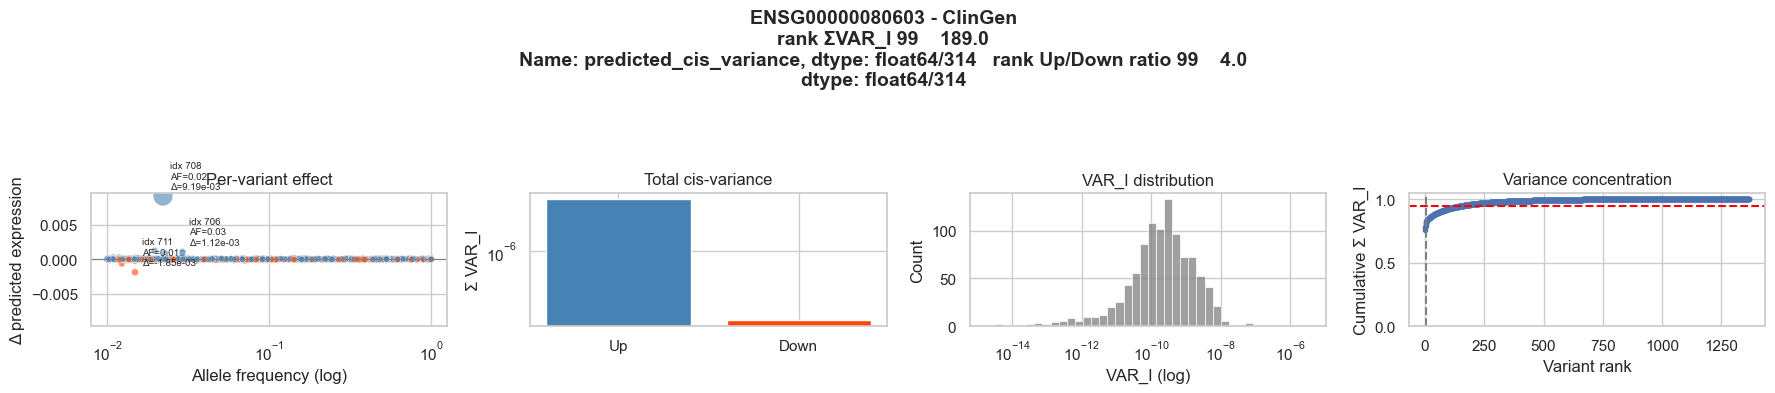

ENSG00000080603  (ClinGen)
variants: 1369   up: 935   down: 434
Σ VAR_I up   = 4.70e-06
Σ VAR_I down = 1.27e-07
Up fraction  = 97.37%
rank ΣVAR_I  = 99    189.0
Name: predicted_cis_variance, dtype: float64/314
rank Up/Down = 99    4.0
dtype: float64/314


In [29]:
for df in (var_df_clingen, var_df_nonessential):
    df["up_down_ratio"] = (
        df["predicted_cis_variance_up"] /
        df["predicted_cis_variance_down"].replace(0, np.nan)
    )

extreme_ratio = (
    var_df_clingen.sort_values("up_down_ratio", ascending=False)
                  .head(4)["gene_id"]
)

for g in extreme_ratio:
    plot_gene_variants(g, cohort="ClinGen")

## 1.2 Non-essential cohort

### 1.2.1 Top genes by total predicted cis-variance in non-essential

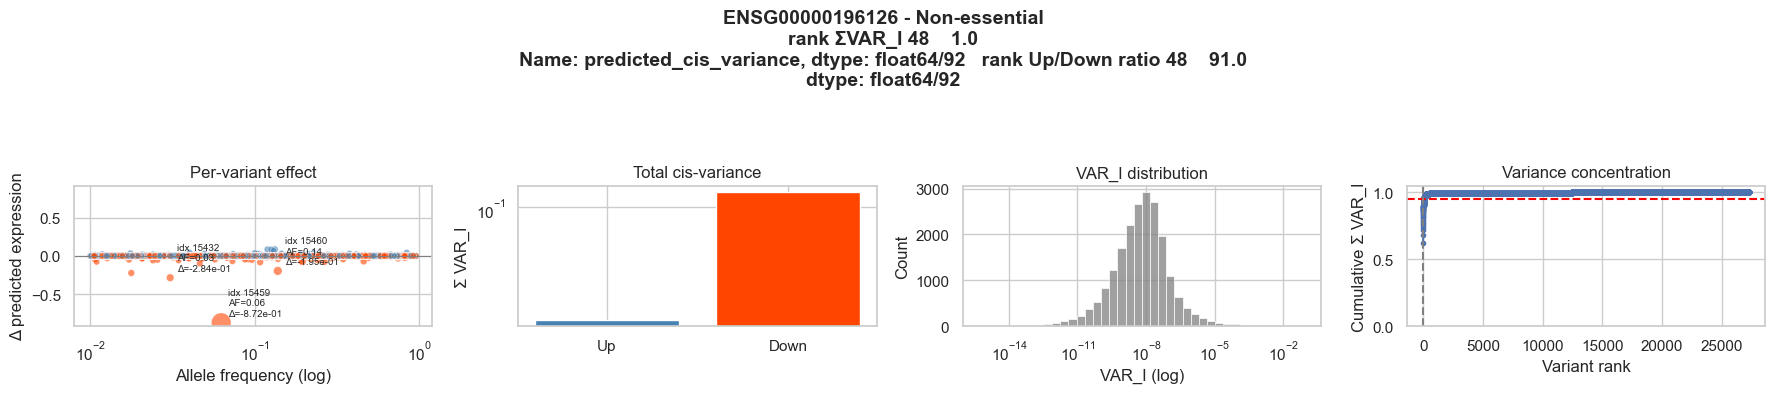

ENSG00000196126  (Non-essential)
variants: 27265   up: 12658   down: 14607
Σ VAR_I up   = 1.37e-02
Σ VAR_I down = 1.31e-01
Up fraction  = 9.49%
rank ΣVAR_I  = 48    1.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 48    91.0
dtype: float64/92


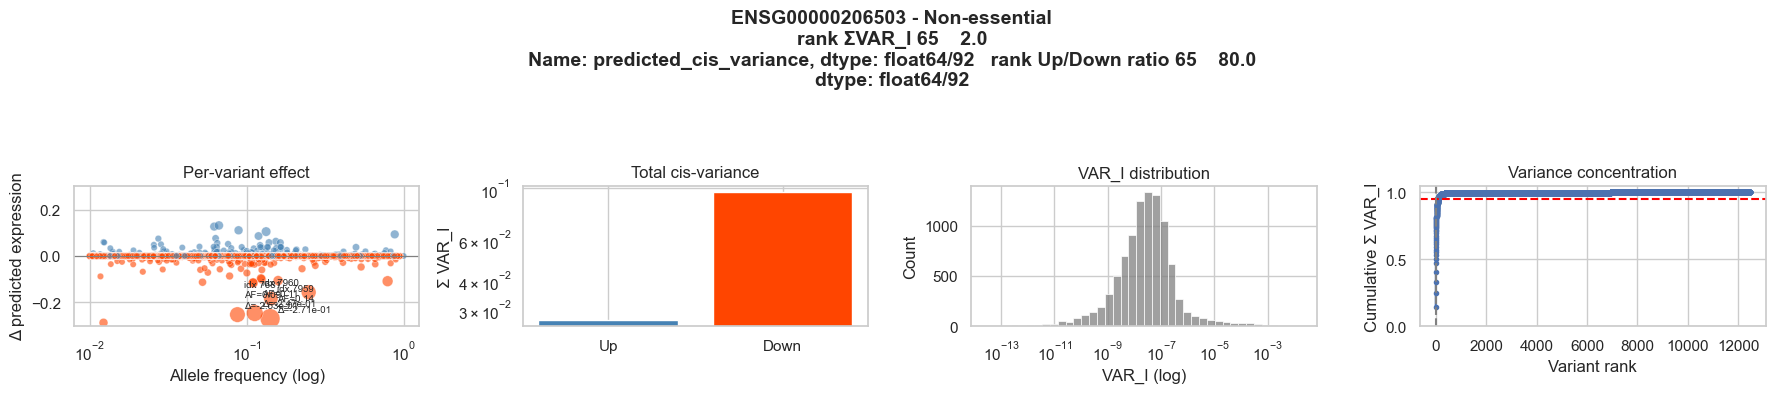

ENSG00000206503  (Non-essential)
variants: 12461   up: 1506   down: 10955
Σ VAR_I up   = 2.68e-02
Σ VAR_I down = 9.55e-02
Up fraction  = 21.91%
rank ΣVAR_I  = 65    2.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 65    80.0
dtype: float64/92


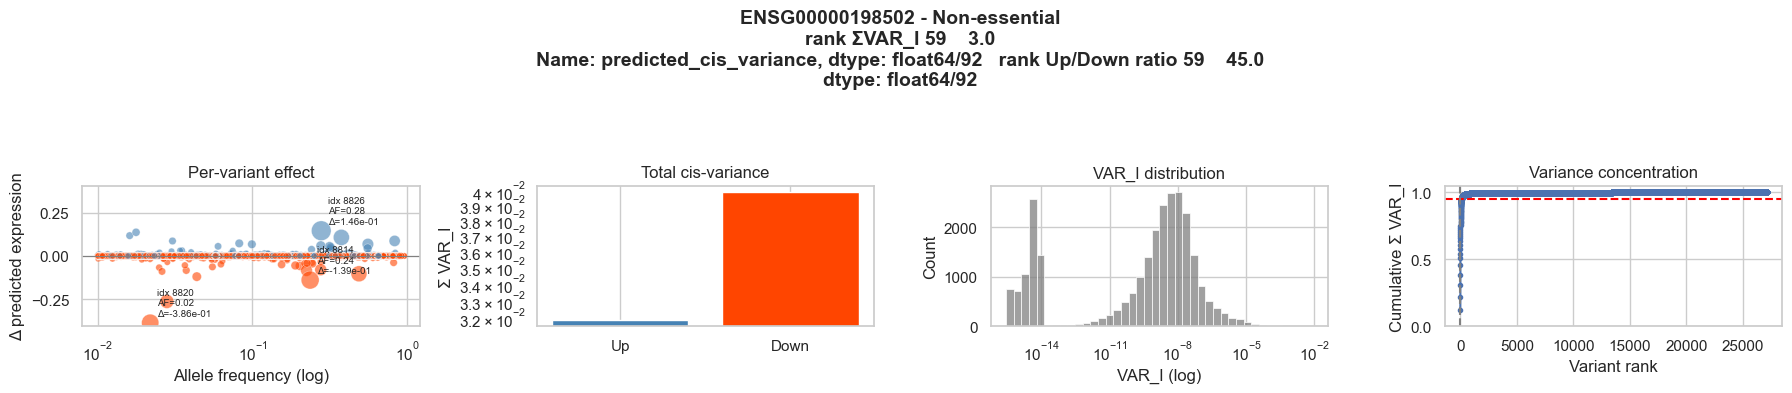

ENSG00000198502  (Non-essential)
variants: 27133   up: 6372   down: 20761
Σ VAR_I up   = 3.18e-02
Σ VAR_I down = 3.98e-02
Up fraction  = 44.44%
rank ΣVAR_I  = 59    3.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 59    45.0
dtype: float64/92


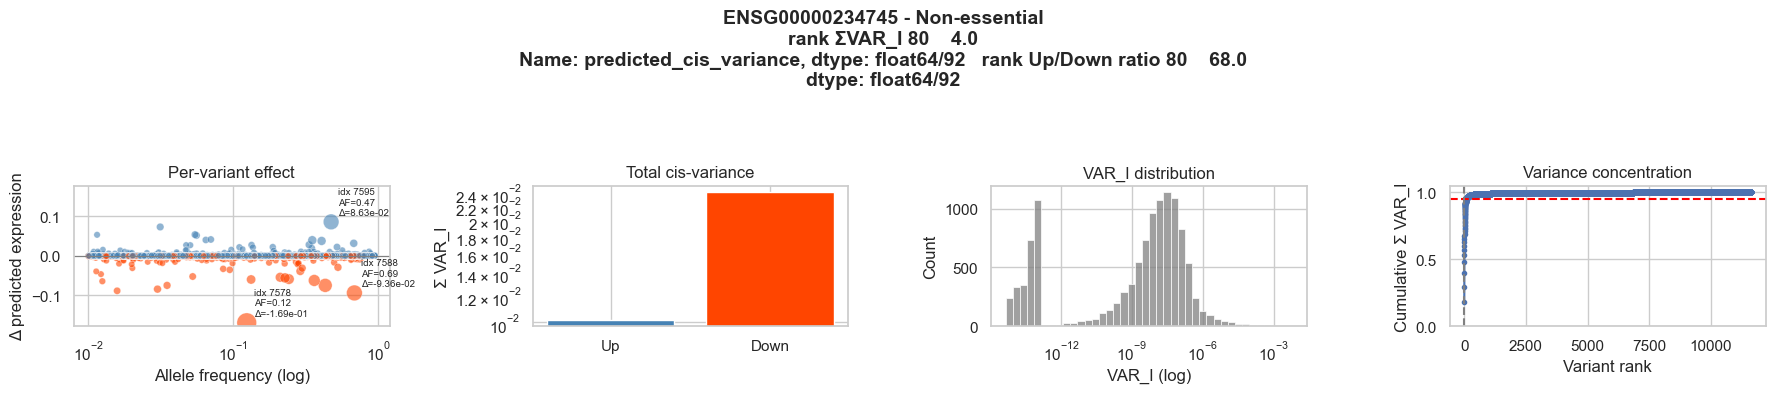

ENSG00000234745  (Non-essential)
variants: 11634   up: 8934   down: 2700
Σ VAR_I up   = 1.02e-02
Σ VAR_I down = 2.41e-02
Up fraction  = 29.68%
rank ΣVAR_I  = 80    4.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 80    68.0
dtype: float64/92


In [30]:
top_nonessential = (
    var_df_nonessential
        .sort_values("predicted_cis_variance", ascending=False)
        .head(4)["gene_id"]
)

for g in top_nonessential:
    plot_gene_variants(g, cohort="Non-essential")

### 1.2.2 The most extreme up–down imbalance

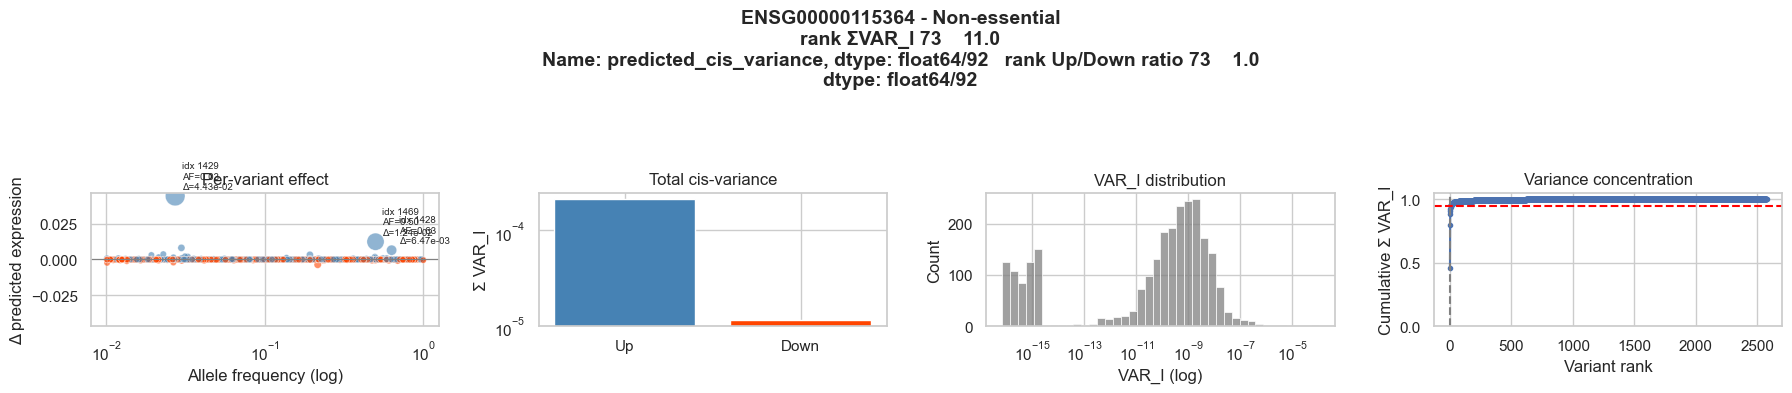

ENSG00000115364  (Non-essential)
variants: 2577   up: 1033   down: 1544
Σ VAR_I up   = 2.14e-04
Σ VAR_I down = 1.15e-05
Up fraction  = 94.91%
rank ΣVAR_I  = 73    11.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 73    1.0
dtype: float64/92


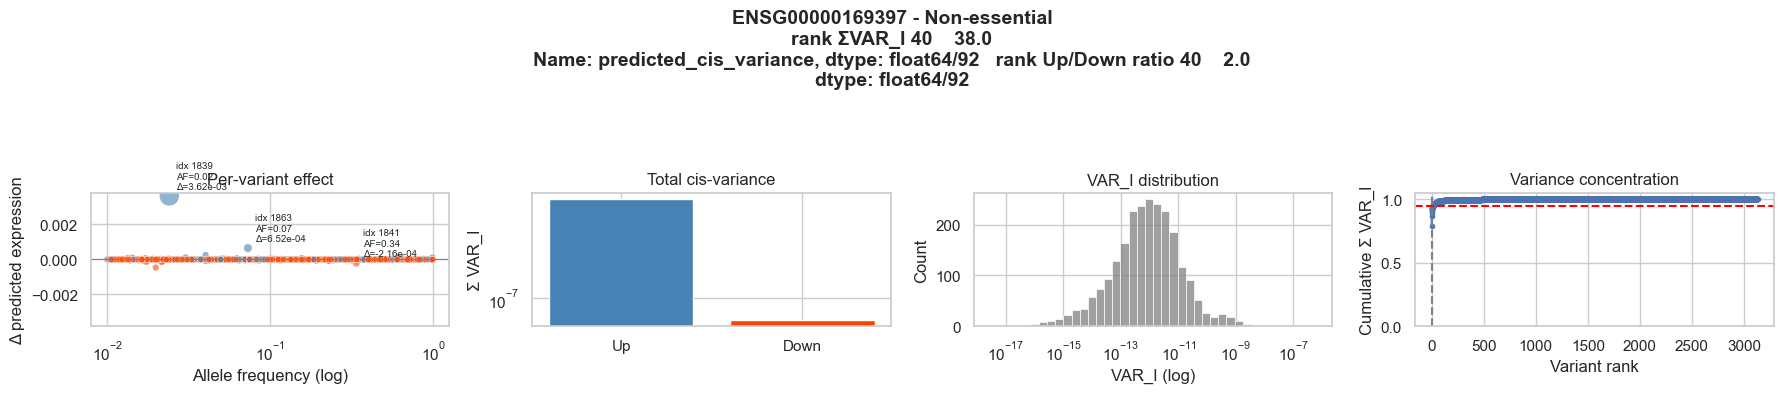

ENSG00000169397  (Non-essential)
variants: 3131   up: 746   down: 2385
Σ VAR_I up   = 7.17e-07
Σ VAR_I down = 6.38e-08
Up fraction  = 91.83%
rank ΣVAR_I  = 40    38.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 40    2.0
dtype: float64/92


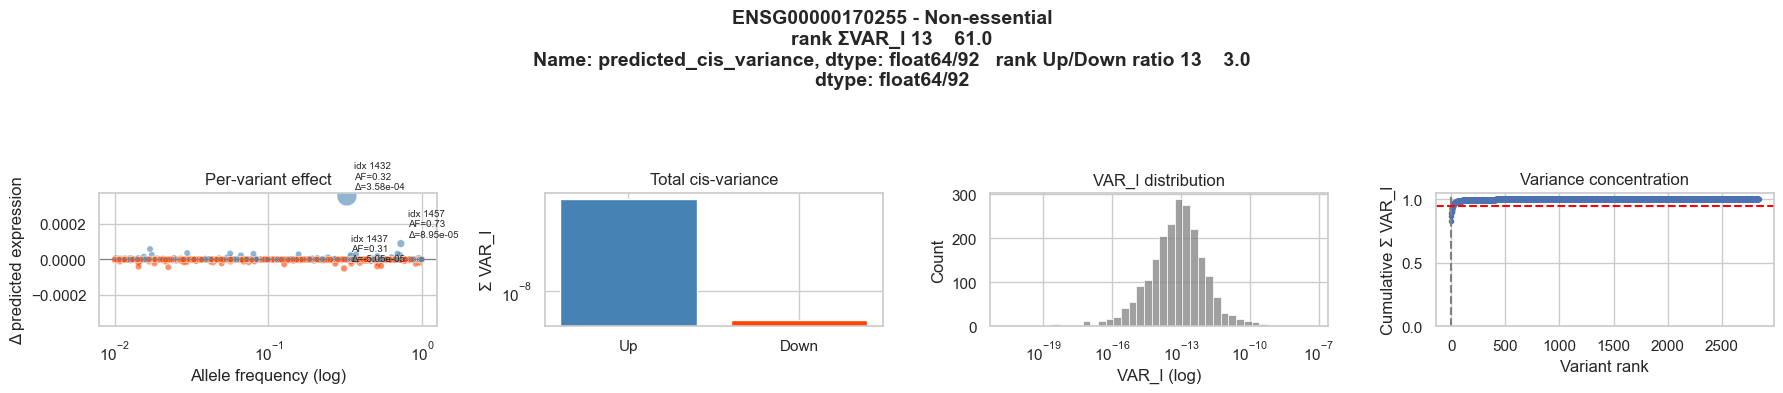

ENSG00000170255  (Non-essential)
variants: 2840   up: 755   down: 2085
Σ VAR_I up   = 6.25e-08
Σ VAR_I down = 5.58e-09
Up fraction  = 91.80%
rank ΣVAR_I  = 13    61.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 13    3.0
dtype: float64/92


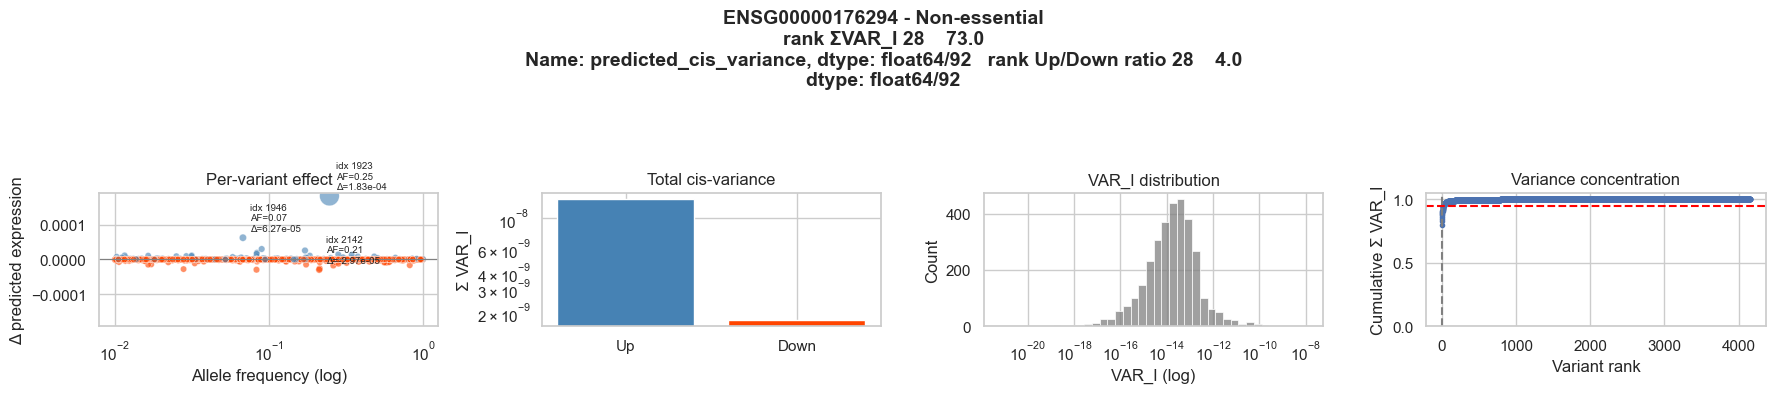

ENSG00000176294  (Non-essential)
variants: 4155   up: 610   down: 3545
Σ VAR_I up   = 1.39e-08
Σ VAR_I down = 1.73e-09
Up fraction  = 88.95%
rank ΣVAR_I  = 28    73.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 28    4.0
dtype: float64/92


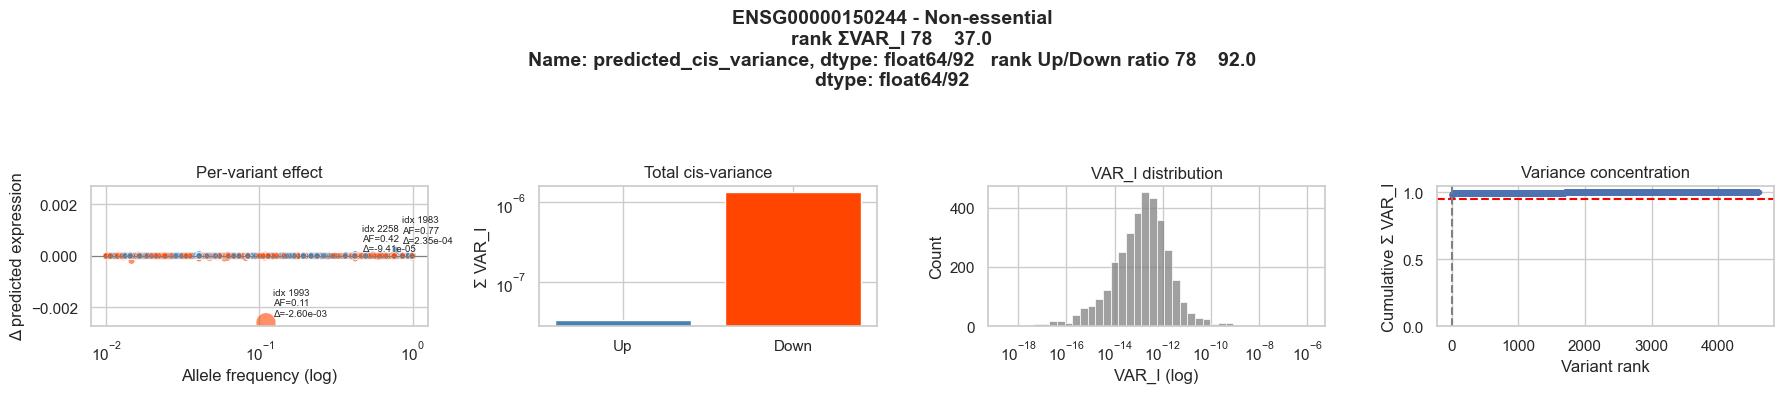

ENSG00000150244  (Non-essential)
variants: 4609   up: 1893   down: 2716
Σ VAR_I up   = 3.38e-08
Σ VAR_I down = 1.34e-06
Up fraction  = 2.46%
rank ΣVAR_I  = 78    37.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 78    92.0
dtype: float64/92


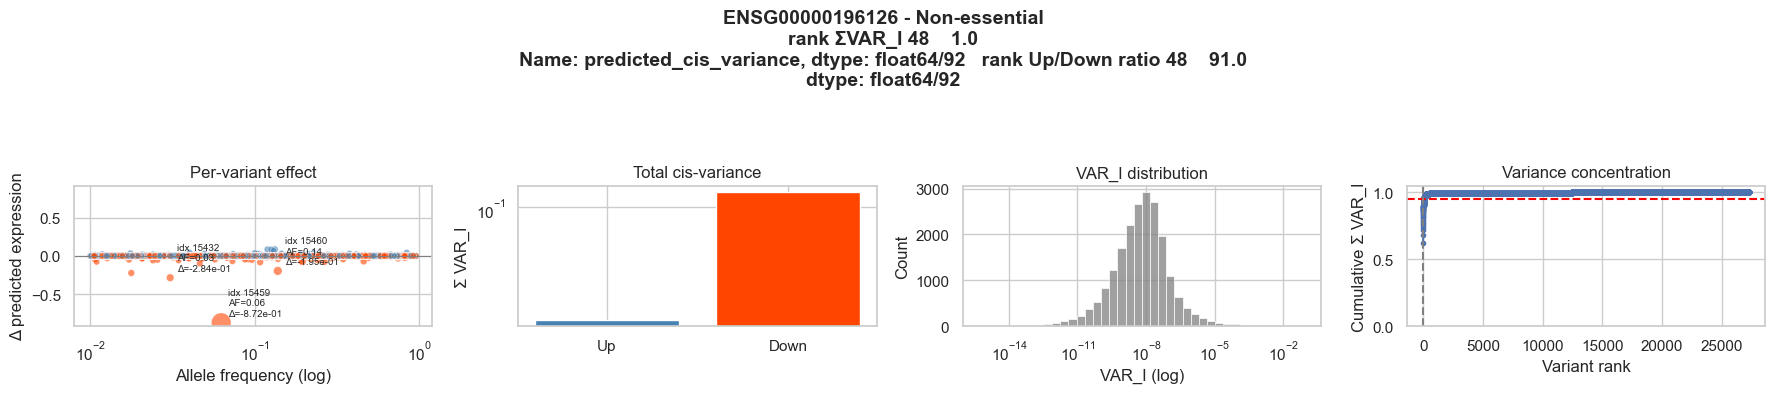

ENSG00000196126  (Non-essential)
variants: 27265   up: 12658   down: 14607
Σ VAR_I up   = 1.37e-02
Σ VAR_I down = 1.31e-01
Up fraction  = 9.49%
rank ΣVAR_I  = 48    1.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 48    91.0
dtype: float64/92


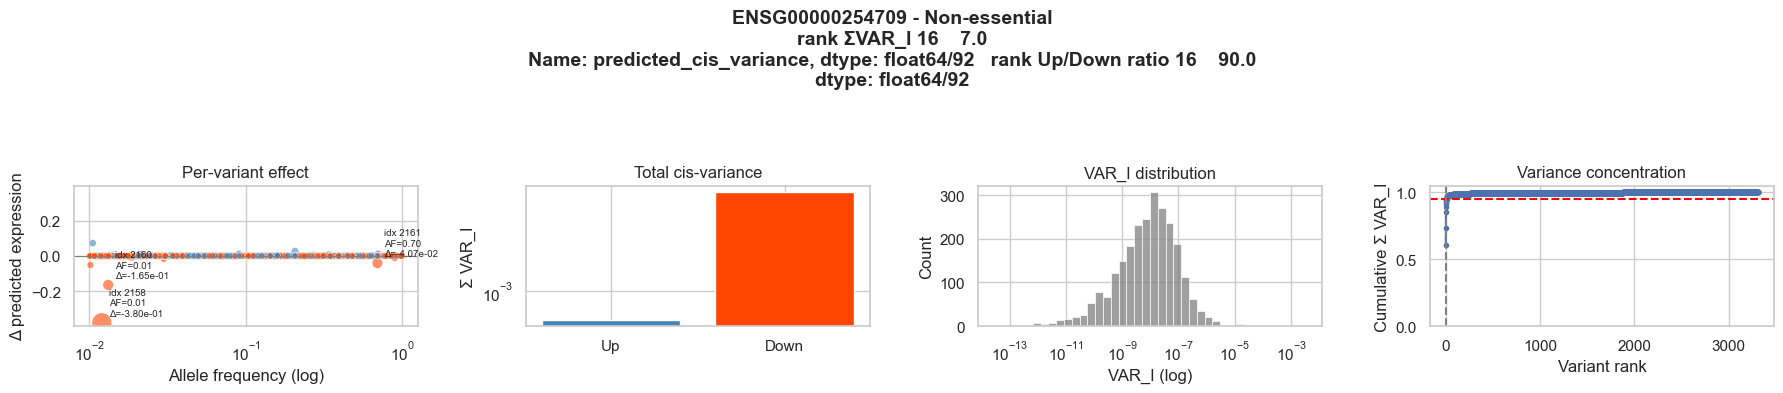

ENSG00000254709  (Non-essential)
variants: 3314   up: 1407   down: 1907
Σ VAR_I up   = 6.21e-04
Σ VAR_I down = 5.04e-03
Up fraction  = 10.95%
rank ΣVAR_I  = 16    7.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 16    90.0
dtype: float64/92


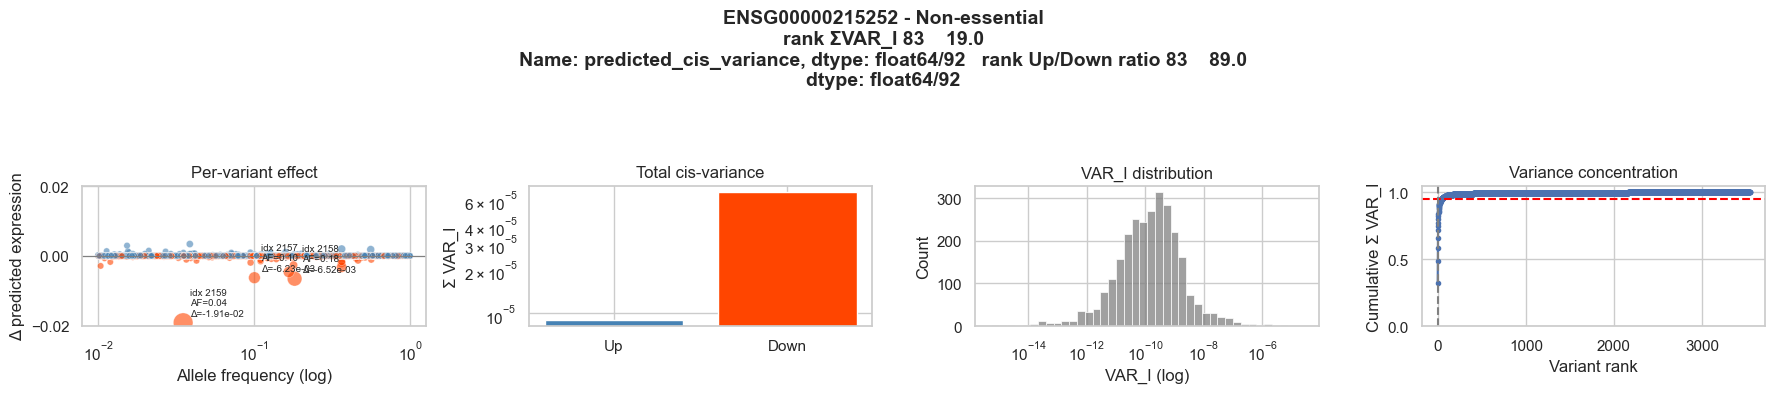

ENSG00000215252  (Non-essential)
variants: 3541   up: 2018   down: 1523
Σ VAR_I up   = 9.06e-06
Σ VAR_I down = 6.76e-05
Up fraction  = 11.82%
rank ΣVAR_I  = 83    19.0
Name: predicted_cis_variance, dtype: float64/92
rank Up/Down = 83    89.0
dtype: float64/92


In [31]:
extreme_ratio_ne = (
    var_df_nonessential
        .sort_values("up_down_ratio", ascending=False)  # biggest Up/Down ratios
        .head(4)["gene_id"]
)

for g in extreme_ratio_ne:
    plot_gene_variants(g, cohort="Non-essential")

down_skewed_ne = (
    var_df_nonessential
        .sort_values("up_down_ratio", ascending=True)
        .head(4)["gene_id"]
)

for g in down_skewed_ne:
    plot_gene_variants(g, cohort="Non-essential")

## Summary

Across both cohorts these plots show that expression variance is almost never evenly distributed.

- A single promoter SNP—sometimes two or three—accounts for ≥ 95 % of the predicted dosage fluctuation in nearly every gene.

- For ClinGen genes that variant is usually up-regulating, whereas in the non-essential set we find both strong up- and strong down-regulating alleles.